### This is the sample script for train and validate xgboost models 
#### Author: Yen-Lin Chen, Pollack Lab, Cornell University

In [1]:
# Define some useful functions

# load some libs
import os
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import xgboost
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics


# The function to load hdf5 files into tensors for traiining data
def load_helix_training_data(datadir):
	
	f = open(os.path.join(datadir, 'data_train.txt'));
	training_datalist = f.read();
	training_datalist = training_datalist.split('\n')[0:-1];
	f.close();
	
	# Getting the x_train, y_train
	x_train = np.zeros((1, 191));
	y_train = np.zeros(1);
	for filename in training_datalist:
		h5file = h5.File(os.path.join(datadir, filename));
		x_train = np.vstack((x_train, np.array(h5file['data'][:,:])));
		y_train = np.hstack((y_train, np.array(h5file['label'][:])));
		print('INFO: %s Processing Done.. ' %filename);

	return (x_train[1:, :], y_train[1:]);


# The function to load hdf file as tensors for validate data
def load_helix_test_data(datadir):
	
	f = open(os.path.join(datadir,'data_test.txt'));
	validate_datalist = f.read();
	validate_datalist = validate_datalist.split('\n')[0:-1];
	f.close();
	
	x_validate = np.zeros((1, 191));
	y_validate = np.zeros(1);
	for filename in validate_datalist:
		h5file = h5.File(os.path.join(datadir, filename));
		x_validate = np.vstack((x_validate, np.array(h5file['data'][:,:])));
		y_validate = np.hstack((y_validate, np.array(h5file['label'][:])));
		print('INFO: %s Processing Done..' %filename);

	return (x_validate[1:, :], y_validate[1:]);


# interpolation
def q_interp(x, npoints):
    
    n = x.shape[0];
    qmin = 0.0; 
    qmax = 0.95; 
    qold = np.linspace(qmin, qmax, num=x.shape[1])
    qnew = np.linspace(qmin, qmax, num=npoints)
    x_interp = np.zeros((n, npoints))
    for i in range(n):
        f = interp1d(qold, x[i, :], kind='cubic')
        x_interp[i, :] = f(qnew)
        
    return x_interp


# get importance 
def get_importance(model, n, im='weight'):
    
    imp = model.get_booster().get_score(importance_type=im)
    keys = imp.keys()
    nkeys = len(keys)
    v = np.zeros(n)
    for i in range(nkeys):
        k = 'f%d' %(i+1)
        try:
            v[i] = imp[k]
        except:
            continue
        
    return v / v.max()

In [2]:
# Set up data directory
datadir = 'G:/My Drive/14. CNNWAXS/data/helical_radius'
prefix = 'radius'
#os.chdir(datadir)

# open a file for logs, we're not using it rn ...
#file = open(prefix + '_stats.dat', 'w');

# load the training data (training/validation)
(x, y) = load_helix_training_data(datadir)

# split the data
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.2, random_state=42)

INFO: helical_radius_train.hdf5 Processing Done.. 


In [3]:
# keeping track of the statistics ... 
#file.write('# Noise-free model : ')

# the xgb regression model
regressmodel = xgboost.XGBRegressor(colsample_bytree=0.4,
                                    gamma=0,                 
                                    learning_rate=0.07,
                                    max_depth=3,
                                    min_child_weight=1.5,
                                    n_estimators=750,                                                                    
                                    reg_alpha=0.75,
                                    reg_lambda=0.45,
                                    subsample=0.8,
                                    seed=42)


In [4]:
# Do a 10-fold cross validation

kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvrlt = cross_val_score(regressmodel, x_train, y_train, scoring='neg_mean_squared_error', cv=kfold, verbose=True)
print('Noise-free 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))
#file.write('Noise-free 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:08:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:11:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:21] WARNI

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.2min finished


In [5]:
# training and using early stopping to get our model 
# Typically stopping iteration is 7000-10000
# verbose = False for demo
regressmodel.n_estimators = 7500
regressmodel.fit(x_train, y_train, 
                 eval_metric='rmse', 
                 eval_set=[(x_validate, y_validate)], 
                 early_stopping_rounds=int(0.01 * regressmodel.n_estimators), 
                 verbose=False) 

# See the performance on the training set
train_preds = regressmodel.predict(x_train)
train_mse = metrics.mean_squared_error(y_train, train_preds)
print('Noise-free Training Result: MSE = %f \n' % train_mse)
#file.write('Noise-free Training Result: MSE = %f \n' % train_mse)

# See the performance on the validation set
validate_preds = regressmodel.predict(x_validate)
validate_mse = metrics.mean_squared_error(y_validate, validate_preds)
print('Noise-free Validation Result: MSE = %f \n' % validate_mse) 
#file.write('Noise-free Validation Result: MSE = %f \n' % validate_mse)

# See the performance on the testing set
(x_test, y_test) = load_helix_test_data(datadir)
test_preds = regressmodel.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Noise-free Testing Result: MSE = %f \n' % test_mse) 
#file.write('Noise-free Testing Result: MSE = %f \n\n' % test_mse)

[15:16:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Noise-free Training Result: MSE = 0.000028 

Noise-free Validation Result: MSE = 0.000044 

INFO: helical_radius_test.hdf5 Processing Done..
Noise-free Testing Result: MSE = 0.000045 



In [6]:
## The noisy regression model 
noise = 0.01 # Let's just try this and see ...
# file.write('Noisy regression model with noise = %f : \n' % noise)
x_train_noise = np.log10(np.multiply(10**x_train, 1 + noise*np.random.rand(x_train.shape[0], x_train.shape[1])))
x_validate_noise = np.log10(np.multiply(10**x_validate, 1 + noise*np.random.rand(x_validate.shape[0], x_train.shape[1])))

# exactly the same xgb model, different name
noiseregressmodel = xgboost.XGBRegressor(colsample_bytree=0.4,
                                    gamma=0,                 
                                    learning_rate=0.07,
                                    max_depth=3,
                                    min_child_weight=1.5,
                                    n_estimators=750,                                                                    
                                    reg_alpha=0.75,
                                    reg_lambda=0.45,
                                    subsample=0.8,
                                    seed=42)

# 10 fold cross validation 
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvrlt = cross_val_score(noiseregressmodel, x_train_noise, y_train, scoring='neg_mean_squared_error', cv=kfold, verbose=True)
print('Noisy 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))
#file.write('Noise-free 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:27:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:34:45] WARNI

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.1min finished


In [7]:
noiseregressmodel.n_estimators = 7500
noiseregressmodel.fit(x_train_noise, y_train, 
                 eval_metric='rmse', 
                 eval_set=[(x_validate_noise, y_validate)], 
                 early_stopping_rounds=int(0.01 * noiseregressmodel.n_estimators), 
                 verbose=False)

# See the performance on the training set
train_preds = noiseregressmodel.predict(x_train_noise)
train_mse = metrics.mean_squared_error(y_train, train_preds)
print('Noisy Training Result: MSE = %f \n' % train_mse)
#file.write('Noisy Training Result: MSE = %f \n' % train_mse)

# See the performance on the validation set
validate_preds = noiseregressmodel.predict(x_validate_noise)
validate_mse = metrics.mean_squared_error(y_validate, validate_preds)
print('Noisy Validation Result: MSE = %f \n' % validate_mse) 
#file.write('Noisy Validation Result: MSE = %f \n' % validate_mse)

# See the performance on the testing set
# trained on noisy data, test on noisy data 
x_test_noise = np.log10(np.multiply(10**x_test, 1 + noise*np.random.rand(x_test.shape[0], x_test.shape[1])))
test_preds = noiseregressmodel.predict(x_test_noise)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Noisy Testing Result: MSE = %f \n' % test_mse) 
#file.write('Noisy Testing Result: MSE = %f \n\n' % test_mse)

[15:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Noisy Training Result: MSE = 0.000119 

Noisy Validation Result: MSE = 0.000549 

Noisy Testing Result: MSE = 0.000553 



In [8]:
## The interpolation model: 100 (down sampling)
nsample = 100
#file.write('Down sampling regression model with nsample = %d : \n' % nsample)
x_train_down = q_interp(x_train, nsample)
x_validate_down = q_interp(x_validate, nsample)

downregressmodel = xgboost.XGBRegressor(colsample_bytree=0.4,
                                    gamma=0,                 
                                    learning_rate=0.07,
                                    max_depth=3,
                                    min_child_weight=1.5,
                                    n_estimators=750,                                                                    
                                    reg_alpha=0.75,
                                    reg_lambda=0.45,
                                    subsample=0.8,
                                    seed=42)

# 10 fold cross validation too
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvrlt = cross_val_score(downregressmodel, x_train_down, y_train, scoring='neg_mean_squared_error', cv=kfold, verbose=True)
print('Down Sampling 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))
#file.write('Down Sampling 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:55:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:30] WARNI

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.5min finished


In [9]:
downregressmodel.n_estimators = 7500
downregressmodel.fit(x_train_down, y_train, 
                 eval_metric='rmse', 
                 eval_set=[(x_validate_down, y_validate)], 
                 early_stopping_rounds=int(0.01 * downregressmodel.n_estimators), 
                 verbose=False)

# See the performance on the training set
train_preds = downregressmodel.predict(x_train_down)
train_mse = metrics.mean_squared_error(y_train, train_preds)
print('Down Sampling Training Result: MSE = %f \n' % train_mse)
#file.write('Down Sampling Training Result: MSE = %f \n' % train_mse)

# See the performance on the validation set
validate_preds = downregressmodel.predict(x_validate_down)
validate_mse = metrics.mean_squared_error(y_validate, validate_preds)
print('Down Sampling Validation Result: MSE = %f \n' % validate_mse) 
#file.write('Down Sampling Validation Result: MSE = %f \n' % validate_mse)

# See the performance on the testing set
x_test_down = q_interp(x_test, nsample)
test_preds = downregressmodel.predict(x_test_down)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Down Sampling Testing Result: MSE = %f \n' % test_mse) 
#file.write('Down Sampling Testing Result: MSE = %f \n\n' % test_mse)

[17:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Down Sampling Training Result: MSE = 0.000032 

Down Sampling Validation Result: MSE = 0.000048 

Down Sampling Testing Result: MSE = 0.000051 



In [10]:
## The interpolation model: 400 (up sampling)
nsample = 400
#file.write('Up sampling regression model with nsample = %d : \n' % nsample)
x_train_up = q_interp(x_train, nsample)
x_validate_up = q_interp(x_validate, nsample)

upregressmodel = xgboost.XGBRegressor(colsample_bytree=0.4,
                                    gamma=0,                 
                                    learning_rate=0.07,
                                    max_depth=3,
                                    min_child_weight=1.5,
                                    n_estimators=750,                                                                    
                                    reg_alpha=0.75,
                                    reg_lambda=0.45,
                                    subsample=0.8,
                                    seed=42)

# 10 fold cross validation too
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvrlt = cross_val_score(upregressmodel, x_train_up, y_train, scoring='neg_mean_squared_error', cv=kfold, verbose=True)
print('Up Sampling 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))
#file.write('Up Sampling 10-fold Cross Validation Result: MSE= %f (%f) \n' % (-cvrlt.mean(), cvrlt.std()))

upregressmodel.n_estimators = 7500
upregressmodel.fit(x_train_up, y_train, 
                 eval_metric='rmse', 
                 eval_set=[(x_validate_up, y_validate)], 
                 early_stopping_rounds=int(0.01 * upregressmodel.n_estimators), 
                 verbose=False)

# See the performance on the training set
train_preds = upregressmodel.predict(x_train_up)
train_mse = metrics.mean_squared_error(y_train, train_preds)
print('Up Sampling Training Result: MSE = %f \n' % train_mse)
#file.write('Up Sampling Training Result: MSE = %f \n' % train_mse)

# See the performance on the validation set
validate_preds = upregressmodel.predict(x_validate_up)
validate_mse = metrics.mean_squared_error(y_validate, validate_preds)
print('Up Smpling Validation Result: MSE = %f \n' % validate_mse) 
#file.write('Up Smpling Validation Result: MSE = %f \n' % validate_mse)

# See the performance on the testing set
x_test_up = q_interp(x_test, nsample)
test_preds = upregressmodel.predict(x_test_up)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Up Sampling Testing Result: MSE = %f \n' % test_mse) 
#file.write('Up Sampling Testing Result: MSE = %f \n\n' % test_mse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:30:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:37:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:40:30] WARNI

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.5min finished


Up Sampling 10-fold Cross Validation Result: MSE= 0.000849 (0.000098) 

[17:47:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Up Sampling Training Result: MSE = 0.000026 

Up Smpling Validation Result: MSE = 0.000041 

Up Sampling Testing Result: MSE = 0.000042 



In [11]:
## try the random dataset and show that our model does not fit the random data. 
## If it fits, then xgb might be just fitting anything
#file.write('Random regression model : \n')
randommodel = xgboost.XGBRegressor(colsample_bytree=0.4,
                                    gamma=0,                 
                                    learning_rate=0.07,
                                    max_depth=3,
                                    min_child_weight=1.5,
                                    n_estimators=7500,                                                                    
                                    reg_alpha=0.75,
                                    reg_lambda=0.45,
                                    subsample=0.8,
                                    seed=42)

y_random = y.min() +  (y.max() - y.min()) * np.random.rand(x.shape[0]);
randommodel.fit(x, y_random, verbose=False)

# See the performance on the random training data
random_preds = randommodel.predict(x)
random_mse = metrics.mean_squared_error(y_random, random_preds)
print('Random Training Result: MSE = %f' % random_mse)
#file.write('Random Training Result: MSE = %f' % random_mse)

# See the performance on the validation set
validate_preds = randommodel.predict(x_validate)
validate_mse = metrics.mean_squared_error(y_validate, validate_preds)
print('Random Validation Result: MSE = %f \n' % validate_mse) 
#file.write('Random Validation Result: MSE = %f \n' % validate_mse)

# See the performance on the testing set
test_preds = randommodel.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Random Testing Result: MSE = %f \n' % test_mse) 
#file.write('Random Testing Result: MSE = %f \n\n' % test_mse)

[18:04:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Random Training Result: MSE = 0.345567
Random Validation Result: MSE = 0.218672 

Random Testing Result: MSE = 0.215838 



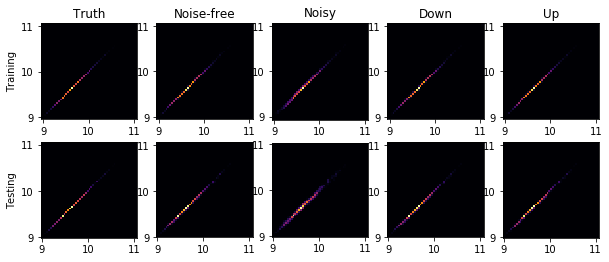

In [12]:
## Plot the confusion matrix
import matplotlib.gridspec as gridspec

p = plt.figure("Confusion Matrices", figsize=[10, 4]);

plt.subplot(2,5,1, aspect='equal'); 
plt.hist2d(y_train, y_train, bins=(50, 50), cmap=plt.cm.inferno);
plt.title('Truth');
plt.ylabel('Training');
plt.subplot(2,5,2, aspect='equal'); 
plt.hist2d(y_train, regressmodel.predict(x_train), bins=(50, 50), cmap=plt.cm.inferno);
plt.title('Noise-free');
plt.subplot(2,5,3, aspect='equal'); 
plt.hist2d(y_train, noiseregressmodel.predict(x_train_noise), bins=(50, 50), cmap=plt.cm.inferno);
plt.title('Noisy');
plt.subplot(2,5,4, aspect='equal'); 
plt.hist2d(y_train, downregressmodel.predict(x_train_down), bins=(50, 50), cmap=plt.cm.inferno);
plt.title('Down');
plt.subplot(2,5,5, aspect='equal'); 
plt.hist2d(y_train, upregressmodel.predict(x_train_up), bins=(50, 50), cmap=plt.cm.inferno);
plt.title('Up');

plt.subplot(2,5,6, aspect='equal'); 
plt.hist2d(y_test, y_test, bins=(50, 50), cmap=plt.cm.inferno);
plt.ylabel('Testing');
plt.subplot(2,5,7, aspect='equal'); 
plt.hist2d(y_test, regressmodel.predict(x_test), bins=(50, 50), cmap=plt.cm.inferno);
plt.subplot(2,5,8, aspect='equal'); 
plt.hist2d(y_test, noiseregressmodel.predict(x_test_noise), bins=(50, 50), cmap=plt.cm.inferno);
plt.subplot(2,5,9, aspect='equal'); 
plt.hist2d(y_test, downregressmodel.predict(x_test_down), bins=(50, 50), cmap=plt.cm.inferno);
plt.subplot(2,5,10, aspect='equal'); 
plt.hist2d(y_test, upregressmodel.predict(x_test_up), bins=(50, 50), cmap=plt.cm.inferno);


Text(0, 0.5, 'Importantance (Weight)')

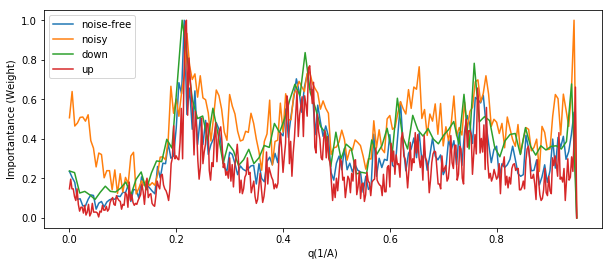

In [13]:
# Plot the importances
down = 100
up = 400
imp_type = 'weight'
q = np.linspace(0.0, 0.95, 191)
q_down = np.linspace(0.0, 0.95, down)
q_up = np.linspace(0.0, 0.95, up)

v = get_importance(regressmodel, 191, im=imp_type)
v_noise = get_importance(noiseregressmodel, 191, im=imp_type)
v_down = get_importance(downregressmodel, down, im=imp_type)
v_up = get_importance(upregressmodel, up, im=imp_type)

p = plt.figure('Information Flow', figsize=[10, 4]);
plt.plot(q, v)
plt.plot(q, v_noise)
plt.plot(q_down, v_down)
plt.plot(q_up, v_up)
plt.legend(['noise-free', 'noisy', 'down', 'up'])
plt.xlabel('q(1/A)')
plt.ylabel('Importantance (Weight)')

Text(0, 0.5, 'Importantance (Weight)')

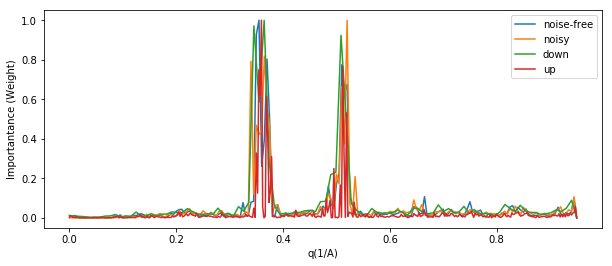

In [14]:
# Plot the importance - gain
imp_type = 'total_gain'
q = np.linspace(0.0, 0.95, 191)
q_down = np.linspace(0.0, 0.95, down)
q_up = np.linspace(0.0, 0.95, up)

v = get_importance(regressmodel, 191, im=imp_type)
v_noise = get_importance(noiseregressmodel, 191, im=imp_type)
v_down = get_importance(downregressmodel, down, im=imp_type)
v_up = get_importance(upregressmodel, up, im=imp_type)

p = plt.figure('Information Flow', figsize=[10, 4]);
plt.plot(q, v)
plt.plot(q, v_noise)
plt.plot(q_down, v_down)
plt.plot(q_up, v_up)
plt.legend(['noise-free', 'noisy', 'down', 'up'])
plt.xlabel('q(1/A)')
plt.ylabel('Importantance (Weight)')

In [15]:
from scipy.signal import savgol_filter
# Sampling from a n x 3 data 
def curve_sampling(data, nsample, chaos=0.05):
    
    n = data.shape[0];
    q = data[:, 0];
    sampled_data = np.zeros((nsample, n));
    for i in range(n):
        sampled_data[:, i] = np.random.normal(data[i, 1], data[i, 2]*chaos, (nsample,));
    for i in range(nsample):
        sampled_data[i, :] = savgol_filter(sampled_data[i, :], 21, 3);
        
    return q, sampled_data; 



In [16]:
err500k = np.loadtxt('F:\\Yen\\DuplexData_Full\\rna12k500.dat');
__, chaos1 = curve_sampling(err500k, 5000, chaos=1.0);
chaos1 = np.log10(chaos1) - np.log10(chaos1[0,0]) + x_train[0,0];
m500k = regressmodel.predict(chaos1).mean() # 9.81 - ish where the real value should be 9.76 +- 0.04
print('The prediction of radius for 500mM KCl data is %f' % m500k)

C:\Users\Yen-Lin\AppData\Roaming\Python\Python37\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\Yen-Lin\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


The prediction of radius for 500mM KCl data is 9.811168


In [17]:
err5mg = np.loadtxt('F:\\Yen\\DuplexData_Full\\rna12mg5.dat');
__, chaos1 = curve_sampling(err5mg, 5000, chaos=0.25); # try a smaller chaos parameter 
chaos1 = np.log10(chaos1) - np.log10(chaos1[0,0]) + x_train[0,0];
m5mg = regressmodel.predict(chaos1).mean() # 9.52 - ish where the real value should be 9.54 +- 0.15
print('The prediction of radius for 5mM MgCl2 data is %f' % m5mg)

The prediction of radius for 5mM MgCl2 data is 9.558842


## The rest of the numbers/figures in the paper were basically generated this way. 


## EOF